 # Advanced Machine Learning - programming assignment 2

*Due: Sunday December 19*

**Please fill in:**
* Amy Oey (7082770)
* Sunny Hsieh (6534856)

### Further instructions:
* Make sure your code is properly commented.
* You can find the required python packages in requirements.txt (Keep in mind, the grader most likely won't install additional packages. Try to stick with the standard library and the packages listed.)
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* **Make sure to name the submitted file according to your and your collaborators last name.** (submitter_collaborator.ipynb)

 ## Reinforcement learning with function approximation

In this assignment, you'll design your own agent to complete an episodic MDP task following the gym framework. The agent will be looking at a small part of the UU logo, and have to decide which of the four compass directions (i.e. left, right, up, down) to move in. The learning task is to find the goal in the center as soon as possible.

The learning objectives of this assignment are:

- Implement two versions of the agent using Semi-gradient SARSA and Q-learning algorithms with a linear approximation function,
- Demonstrate the difference between on-policy and off-policy RL methods,
- Learn to integrate the approximation function with Tabular RL methods,
- Play with the parameters discounted factor $\gamma$ and stepsize $\alpha$ and understand their influence on the learning procedure. 


### 1. Let's start with setting up the enviroment.

The following code defines various aspects of the environment.

In [1]:
import itertools as it
from abc import ABC, abstractmethod
from enum import IntEnum
from typing import List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gym import spaces
from IPython import display
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
from scipy import stats
from tqdm.notebook import tqdm  # For progress bars

In [2]:
# %matplotlib inline
# Constants defining the environment
GOAL = (140, 120)
CENTER = (132, 132)
AVG_MOVEMENT_SIZE = 24
ACCEPTABLE_DISTANCE_TO_GOAL = (AVG_MOVEMENT_SIZE // 2) + 1
RADIUS = 72
WINDOW_SIZE = 28
TIME_LIMIT = 200
TIMEOUT_REWARD = -100.0
MOVE_REWARD = -1
INVALID_MOVE_REWARD = -5


# This is for type inference
State = Tuple[int, int]


# Action space
class Actions(IntEnum):
    NORTH = 0
    EAST = 1
    SOUTH = 2
    WEST = 3


# Boundaries
class Boundary(IntEnum):
    WEST = CENTER[0] - RADIUS
    EAST = CENTER[0] + RADIUS
    NORTH = CENTER[1] - RADIUS
    SOUTH = CENTER[1] + RADIUS


class MovementArea(IntEnum):
    WEST = Boundary.WEST - (WINDOW_SIZE // 2)
    EAST = Boundary.EAST + (WINDOW_SIZE // 2)
    NORTH = Boundary.NORTH - (WINDOW_SIZE // 2)
    SOUTH = Boundary.SOUTH + (WINDOW_SIZE // 2)


# Image
ORIGINAL_IMAGE = plt.imread("UU_LOGO.png")
# Convert to one color channel (using only the red channel), with white background
IMAGE = ORIGINAL_IMAGE[:, :, 0] * ORIGINAL_IMAGE[:, :, 3] + (1.0 - ORIGINAL_IMAGE[:, :, 3])


# Get a "camera view" at the position indicated by state
# Use reshape=True to format the output as a data point for the neural network
def get_window(state: State, reshape=False) -> np.ndarray:
    # When indexing the image as an array, switch the coordinates: im[state[1], state[0]]
    window = IMAGE[(state[1] - 14):(state[1] + 14), (state[0] - 14):(state[0] + 14)]
    if reshape:
        return np.reshape(window, (1, 28, 28, 1))
    return window


# Is the state close enough to the goal to be considered a success?
# There is a margin for error, so that the agent can't jump over the goal
def is_goal_reached(state: State) -> bool:
    if np.amax(np.abs(np.asarray(state) - np.asarray(GOAL))) <= AVG_MOVEMENT_SIZE / 2 + 1:
        return True
    return False


# This is a helper function to render a run
def updatefig(j, images, imgplot, text_act_plot, text_reward_plot):
    # set the data in the axesimage object
    img, time_point, from_state, to_state, act, current_reward = images[min(len(images), j)]
    imgplot.set_data(img)
    text_act_plot.set_text(f"Time step: {time_point} - Action: {act}\nState: {from_state} -> {to_state}")
    text_reward_plot.set_text(f"Current total reward: {current_reward}")
    # return the artists set
    return [imgplot, text_act_plot]


# This will render a run of a full epoch
# The function needs a list of tuples containing an image array, a State, the performed action
def render_epoch(animation_data: List[Tuple[np.ndarray, State, Actions]], interval=100, blit=True, **kwargs):
    if not len(animation_data):
        return f"No images in the list"
    fig, ax = plt.subplots()
    imgplot = ax.imshow(np.zeros_like(animation_data[0][0]))
    text_act_plot = ax.set_title("", color="red", fontweight="extra bold", loc="left")
    text_reward_plot = ax.text(5, 255, "", color="red", fontweight="extra bold")
    params = [animation_data, imgplot, text_act_plot, text_reward_plot]
    ani = FuncAnimation(fig,
                        updatefig,
                        fargs=params,
                        frames=len(animation_data),
                        interval=interval,
                        blit=blit,
                        **kwargs)
    animation = HTML(ani.to_jshtml())
    plt.close()
    return display.display(animation)



 The following 2 images show:
 * The original image, with a red dot marking the goal and a red rectangle marking the area where the center of agent must remain. A movement that would take the agent outside this rectangle, places him at the boundary instead. The blue rectangle represents the area the agent is able to see, which is slightly bigger than the area in which it can move.
 * What the agent sees if s/he is exactly at the goal.

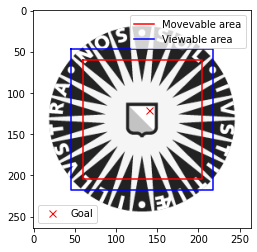

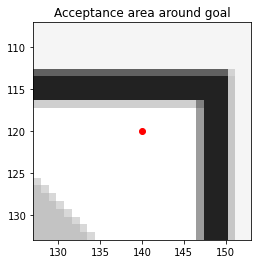

In [3]:
plt.imshow(IMAGE[:, :], cmap='gray', vmin=0, vmax=1.0)
# Plotting uses reversed y-axis now: larger y values are further down
goal_container = plt.plot(GOAL[0], GOAL[1], 'rx', markersize="7")
legend2 = plt.legend(goal_container, ["Goal"], loc=3)

plt.plot([Boundary.WEST, Boundary.WEST, Boundary.EAST, Boundary.EAST, Boundary.WEST],
         [Boundary.NORTH, Boundary.SOUTH, Boundary.SOUTH, Boundary.NORTH, Boundary.NORTH],
         'r-',
         label="Movevable area")
plt.plot([MovementArea.WEST, MovementArea.WEST, MovementArea.EAST, MovementArea.EAST, MovementArea.WEST],
         [MovementArea.NORTH, MovementArea.SOUTH, MovementArea.SOUTH, MovementArea.NORTH, MovementArea.NORTH],
         'b-',
         label="Viewable area")

plt.legend()
plt.gca().add_artist(legend2)
plt.show()

# window around goal
img_container = plt.imshow(get_window(GOAL),
                           cmap='gray',
                           vmin=0,
                           vmax=1.0,
                           extent=(GOAL[0] - ACCEPTABLE_DISTANCE_TO_GOAL, GOAL[0] + ACCEPTABLE_DISTANCE_TO_GOAL,
                                   GOAL[1] + ACCEPTABLE_DISTANCE_TO_GOAL, GOAL[1] - ACCEPTABLE_DISTANCE_TO_GOAL))
plt.plot(GOAL[0], GOAL[1], 'ro', linewidth=1)
plt.title("Acceptance area around goal")
plt.show()



 The following functions complete the definition of the environment. The agent's movements always go in the intended direction, but the distance travelled has a small random component. Besides by reaching the goal, the episode also terminates after TIME_LIMIT (200) steps; at that point, the agent gets a negative reward TIMEOUT_REWARD.

In [4]:
class Environment(gym.Env):
    metadata = {'render.modes': ['human', 'rgba_array']}
    bx = np.array([MovementArea.WEST, MovementArea.WEST, MovementArea.EAST, MovementArea.EAST, MovementArea.WEST])
    by = np.array([MovementArea.NORTH, MovementArea.SOUTH, MovementArea.SOUTH, MovementArea.NORTH, MovementArea.NORTH])

    def __init__(self):
        self.num_actions = Actions
        self.action_space = spaces.Discrete(len(self.num_actions))
        self.observation_space = spaces.Discrete(1)
        self.display = None
        self.img, self.img_container = Environment._init_visual_area(IMAGE)
        self.time = 0

    def seed(self, seed=None) -> int:
        np.random.seed(seed)
        return seed

    def step(self, action: Actions):
        assert self.action_space.contains(action)
        (x, y), was_invalid = self._validate_state(self._move(self.state, action))

        self.state = (x, y)
        reward = MOVE_REWARD if not was_invalid else INVALID_MOVE_REWARD
        reward = TIMEOUT_REWARD if self.time >= TIME_LIMIT else reward
        reward = self.time * reward
        done = is_goal_reached(self.state) or self.time >= TIME_LIMIT
        self.time += 1
        return self.state, reward, done, {}

    def reset(self, state: State = None) -> State:
        self.state = self.starting_state() if not state else state
        self.time = 0
        return self.state

    # returns the current environment situation
    def render(self, mode='rgba_array'):
        curr_img = np.array(self.img_container.get_array())
        x, y = self.state
        scaler = 4
        w, e, n, s = x - scaler, x + scaler, y - scaler, y + scaler
        curr_img[n:s, w:e, 0] = 255
        curr_img[n:s, w:e, 1] = 0
        curr_img[n:s, w:e, 2] = 255
        curr_img[n:s, w:e, 3] = 255
        cropped_img = curr_img  # Just for debugging purposes
        if mode == 'rgba_array':
            plt.close()
            return cropped_img  # return RGB frame suitable for video
        if mode == 'human':
            container = plt.imshow(curr_img)
            ax = container.axes
            ax.set_xlim(Boundary.WEST, Boundary.EAST, auto=None)
            ax.set_ylim(Boundary.SOUTH, Boundary.NORTH, auto=None)
            return container
        else:
            raise Exception(f"Please specify either 'rgba_array' or 'human' as mode parameter!")

    # Return a randomly chosen non-terminal state as starting state
    def starting_state(self) -> State:
        while True:
            state = (
                np.random.randint(Boundary.WEST, Boundary.EAST + 1),
                np.random.randint(Boundary.NORTH, Boundary.SOUTH + 1),
            )
            if not is_goal_reached(state):
                return state

    @staticmethod
    def _move(state: State, action: Actions) -> State:
        x, y = state
        if action == Actions.NORTH:
            y -= AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        elif action == Actions.SOUTH:
            y += AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        elif action == Actions.WEST:
            x -= AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        elif action == Actions.EAST:
            x += AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        return x, y

    @staticmethod
    def _validate_state(state: State) -> Tuple[State, bool]:
        x, y = state
        is_invalid = False
        if y < Boundary.NORTH:
            is_invalid = True
            y = int(Boundary.NORTH)
        if y > Boundary.SOUTH:
            is_invalid = True
            y = int(Boundary.SOUTH)
        if x < Boundary.WEST:
            is_invalid = True
            x = int(Boundary.WEST)
        if x > Boundary.EAST:
            is_invalid = True
            x = int(Boundary.EAST)
        return (x, y), is_invalid

    @staticmethod
    def _init_visual_area(img) -> np.ndarray:
        x, y = img.shape
        my_dpi = 80
        fig = Figure(figsize=(y / my_dpi, x / my_dpi), dpi=my_dpi)
        canvas = FigureCanvasAgg(fig)
        ax = fig.gca()

        ax.plot(GOAL[0], GOAL[1], 'ro', linewidth=5)
        ax.plot(Environment.bx, Environment.by, 'b-')
        img_container = ax.imshow(img[:, :], cmap='gray', vmin=0, vmax=1.0)
        ax.axis('off')
        fig.tight_layout()
        canvas.draw()  # draw the canvas, cache the renderer
        s, (width, height) = canvas.print_to_buffer()
        image = np.frombuffer(s, np.uint8).reshape((height, width, 4))
        img_container.set_data(image)
        plt.close()
        return image, img_container



### 2. Implement your agent

Next comes your part. The following class is responsible for the agent's behavior. The select_action function should implement the epsilon-greedy policy, and return an action chosen according to that policy. **Please fill in the missing codes in select_action function (1.5 points).** 

 Remark: This is an abstract class.
 Hence, its sole purpose is creating subclasses from it, which is also the reason it cannot be instantiated.
 The following subsequent subclasses will provide a specific implementation for the methods that are missing here.
 Therefore, you can ignore the functions that are not implemented. This is just a common way to make sure that all subclasses behave similarly.

In [5]:
class Agent(ABC):
    def __init__(self, alpha: float, gamma: float, epsilon: float):
        # set up the value of epsilon
        self.alpha = alpha  # learning rate or step size
        self.gamma = gamma  # discount rate
        self.epsilon = epsilon  # exploration rate
        self.hist = []    

    # Choose action at state based on epsilon-greedy policy and valueFunction
    def select_action(self, state: Tuple[int, int], is_greedy: bool = True) -> int:

        # TO BE FILLED (1.5 points)

        ###
        # epsilon greedy
        rand = np.random.random() #random number between 0 and 1
        pos_actions = [0,1,2,3]
        if not is_greedy: #when epsilon_greedy policy is used
          if rand < self.epsilon:  #random action
               best_actions = pos_actions
          else: #select best action
               winner = np.argwhere(self.values(state) == np.amax(self.values(state)))
               best_actions = winner.flatten().tolist()
        else: #when epsilon_greedy is not used
          winner = np.argwhere(self.values(state) == np.amax(self.values(state)))
          best_actions = winner.flatten().tolist()


        values = self.values(state)

        self.hist.append(values)
        return int(np.random.choice(best_actions))

    # Return estimated action value of given state and action
    @abstractmethod
    def value(self, state: State, action: Actions) -> float:
        pass

    # Return vector of estimated action values of given state, for each action
    @abstractmethod
    def values(self, state: State) -> np.ndarray:
        pass

    # learn with given state, action and target
    @abstractmethod
    def learn(self, state: State, action: Actions, next_state: State, reward: float, done: bool = False):
        pass

    # Return estimated state value, based on the estimated action values
    def state_value(self, state):
        return np.max(self.values(state))

    # Plot the state value estimates. Use a larger stride for lower resolution.
    def plot_state_values(self, stride=1):
        self.v = np.zeros(
            ((Boundary.SOUTH - Boundary.NORTH + stride) // stride, (Boundary.EAST - Boundary.WEST + stride) // stride))
        for j, x in enumerate(range(Boundary.WEST, Boundary.EAST + 1, stride)):
            for i, y in enumerate(range(Boundary.NORTH, Boundary.SOUTH + 1, stride)):
                self.v[i, j] = self.state_value((x, y))

        plt.imshow(self.v)
        plt.colorbar()
        return plt.show()

    def plot_q_values(self, skip=1):
        return pd.DataFrame(self.hist[::skip]).plot()


 The next classes are two agents using either episodic semi-gradient Q-learning and episodic semi-gradient SARSA algorithm to estimate the value function. Both agents use the same linear function approximation method with tile coding. **Implement the `learn` function according to the update rule for the respective algorithm (1 point for each)**. 
 
 REMARK: Both agents use the same tile coding. This method helps splitting the state-space into discrete chunks. Each chunk is associated with one weight.

In [6]:
# This class handles the function approximation, with several methods to query and update it. 
# A linear approximation function is used, making the computation much faster.
class QAgent(Agent):
    def __init__(self, alpha: float, gamma: float, epsilon: float):
        super().__init__(alpha, gamma, epsilon)
        # Use a tile coding with only a single tiling (i.e. state aggregation):
        # a grid of square tiles
        self.tile_size = 16
        self.W_SHAPE = ((Boundary.SOUTH - Boundary.NORTH + self.tile_size) // self.tile_size,
                        (Boundary.EAST - Boundary.WEST + self.tile_size) // self.tile_size, 4)
        self.w = np.zeros(self.W_SHAPE)
        print(self.w.shape)
        print(type(self.w))

    # Return estimated action value of given state and action
    def value(self, state, action):
        if is_goal_reached(state):
            return 0.0
        return self.w[(state[1] - Boundary.NORTH) // self.tile_size, (state[0] - Boundary.WEST) // self.tile_size,
                      action]

    # Return vector of estimated action values of given state, for each action
    def values(self, state):
        if is_goal_reached(state):
            return np.zeros(4)
        return self.w[(state[1] - Boundary.NORTH) // self.tile_size, (state[0] - Boundary.WEST) // self.tile_size, :]

    # learn with given state, action and target
    def learn(self, state: State, action: Actions, next_state: State, reward: float, done: bool = False):
        # TO BE FILLED (1 point)
        # episodic semi-gradient Q-learning
        # according to the update rule for the respective algorithm
        state_x = ((state[0] - Boundary.WEST) // self.tile_size)
        state_y = ((state[1] -Boundary.NORTH) // self.tile_size)
        if done:
          self.w[state_y][state_x][action] = self.w[state_y][state_x][action] + self.alpha * (reward - self.value(state, action))
        else:
          self.w[state_y][state_x][action] = self.w[state_y][state_x][action] + self.alpha * (reward + self.gamma * np.max(self.values(next_state)) - self.value(state, action))



In [7]:
class SARSAAgent(Agent):
    def __init__(self, alpha: float, gamma: float, epsilon: float):
        super().__init__(alpha, gamma, epsilon)

        # Use a tile coding with only a single tiling (i.e. state aggregation):
        # a grid of square tiles
        self.tile_size = 16
        self.W_SHAPE = ((Boundary.SOUTH - Boundary.NORTH + self.tile_size) // self.tile_size,
                        (Boundary.EAST - Boundary.WEST + self.tile_size) // self.tile_size, 4)
        self.w = np.zeros(self.W_SHAPE)

    # Return estimated action value of given state and action
    def value(self, state, action):
        if is_goal_reached(state):
            return 0.0
        return self.w[(state[1] - Boundary.NORTH) // self.tile_size, (state[0] - Boundary.WEST) // self.tile_size,
                      action]

    # Return vector of estimated action values of given state, for each action
    def values(self, state):
        if is_goal_reached(state):
            return np.zeros(4)
        return self.w[(state[1] - Boundary.NORTH) // self.tile_size, (state[0] - Boundary.WEST) // self.tile_size, :]

    # learn with given state, action and target
    def learn(self, state: State, action: Actions, next_state: State, reward: float, done: bool = False):
        
        # TO BE FILLED (1 point)
        # episodic semi-gradient SARSA algorithm
        # according to the update rule for the respective algorithm
        state_x = ((state[0] - Boundary.WEST) // self.tile_size)
        state_y = ((state[1] -Boundary.NORTH)  // self.tile_size)

        if done:
          self.w[state_y][state_x][action] = self.w[state_y][state_x][action] + self.alpha * (reward - self.value(state, action))
        else:
          next_action = self.select_action(next_state, is_greedy = False)
          self.w[state_y][state_x][action] = self.w[state_y][state_x][action] + self.alpha * (reward + self.gamma * (self.value(next_state, next_action)) - self.value(state, action))
          return next_action


 The following function handles the interaction between agent and environment for a single episode. By passing the same value_function object in multiple calls to this function, the agent can learn from a sequence of such interactions.

 **Please fill in the missing parts (1 point).** 

In [8]:
# env: Environment in which the agent is supposed to run 
# agent: agent to learn
# initital state: Starting state for the environment
# is_learning: should the value function be updated during the simulation?
# is_rendering: should the run be recorded? (Takes some time to compute)


def run_episode(env: Environment,
                agent: Agent,
                initial_state: State,
                is_learning: bool = True,
                is_rendering: bool = False) -> Tuple[State, float]:
    # Initialize reward for episode
    total_reward = 0.0
    # Initialize
    is_greedy = not is_learning
    # Get initial action
    current_state = initial_state
    current_action = agent.select_action(initial_state, is_greedy=is_greedy)

    # Track the rendering
    animation_data = []
    animation_data.append((env.render(), env.time, None, current_state, None, 0))
    # Initialize variables
    next_state = None
    done = False

    while not done:
        #TO DO
        next_state, reward, done, _ = env.step(current_action)
        
        total_reward += reward
        if is_rendering:
            curr_img = env.render()
            animation_data.append((curr_img, env.time, current_state, next_state, current_action, total_reward))
        
        # Execute the learning and update the state and action
        # TO BE FILLED (1 point)
        if is_learning == True:
          if agent.__class__.__name__ == 'SARSAAgent':
            next_action = agent.learn(current_state, current_action, next_state, reward, done)
          elif agent.__class__.__name__ == 'QAgent':
            agent.learn(current_state, current_action, next_state, reward, done)
            next_action = agent.select_action(next_state, is_greedy=is_greedy)
            #OR next_action = agent.select_action(current_state, is_greedy=is_greedy) ???
          else:
            raise NotImplementedError
        else:
          next_action = agent.select_action(next_state, is_greedy=is_greedy)
          ##OR next_action = agent.select_action(current_state, is_greedy=is_greedy) ???

        #Update parameters
        current_action = next_action
        current_state = next_state

    return current_state, total_reward, animation_data


 To help understand your agent, you can render the agent's performance by setting render to True and running the `run_epoch` function. 
 
 There are some helper functions. They might help you implement the agent correctly. 
 * `agent.plot_state_values` shows you how the agent values different states
 * `agent.plot_q_values` shows the q_values that the agent had over the course of his life time. (That could be a lot. There's a skip parameter to reduce the amount of data points)

(10, 10, 4)
<class 'numpy.ndarray'>


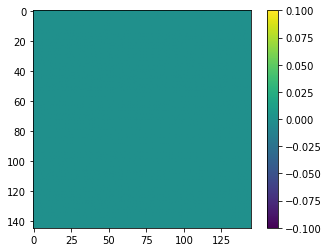

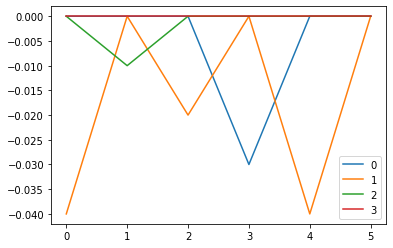

In [9]:
env = Environment()
epsilon = 0.01
gamma = .7
alpha = 1e-2
#agent = SARSAAgent(alpha, gamma, epsilon)
agent = QAgent(alpha, gamma, epsilon)
start_state = env.reset()
end_state, total_reward, animation_data = run_episode(env, agent, start_state, is_learning=True, is_rendering=True)
agent.plot_state_values()
agent.plot_q_values(skip=1)
render_epoch(animation_data, interval=100)


### 3. Run the simulation, play with parameters and analyse results

 Now it's time to train both algorithms/agents on the environment. 
 
 In the simulations, please plot the measure of each algorithm's performance as a function of the episode (i.e. the sum of all immediate rewards received in each episode). You shall play with a few combinations of two parameters discounted factor $\gamma$ and stepsize $\alpha$ (at least two variables for each parameter). During the experiments, keep $\epsilon$ fixed at $0.01$. A reasonable starting point for $\alpha$ is 1e-2. 
 
 REMARK: You can save the parameters and update-to-date Q table of each agent, so that you can still test their performance later. (You can achieve this by keeping the object.)
 

**3.1 Please submit your code as well as the plots presenting compariable performance of the different combinations of parameters for every algorithms (2 points)**. 

REMARK: For a decent comparison all agents should be plotted on the same axis bounds.

In [10]:
# Your code here for running the simulation and ploting the sum of immediate reward in each episode.
# TO BE FILLED.

# Init the environment and run Q-Learning & SARSA
env = Environment()
epsilon = 0.01
gamma = [0.1, 0.5, 0.7]
alpha = [1e-4, 1e-2, 0.1]
rewards_agents = []
episodes = 1000
agentlist = []
alphagamma = []

for i in alpha:
    for j in gamma:
        agent = SARSAAgent(i, j, epsilon)
        #agent = QAgent(i, j, epsilon)
        ep = 0
        rewards_per_episode = []
        while ep < episodes:
            start_state = env.reset()
            end_state, total_reward, animation_data = run_episode(env, agent, start_state, is_learning=True, is_rendering=True)
#             if ((ep/episodes)%0.25 == 0):
#                 print(ep/episodes*100, "%")
            rewards_per_episode.append(total_reward)
            ep = ep + 1
        
        rewards_agents.append(rewards_per_episode) #list of lists
        agentlist.append(agent)
        alphagamma.append((i,j))

# Save and plot the results
# agent.plot_state_values()


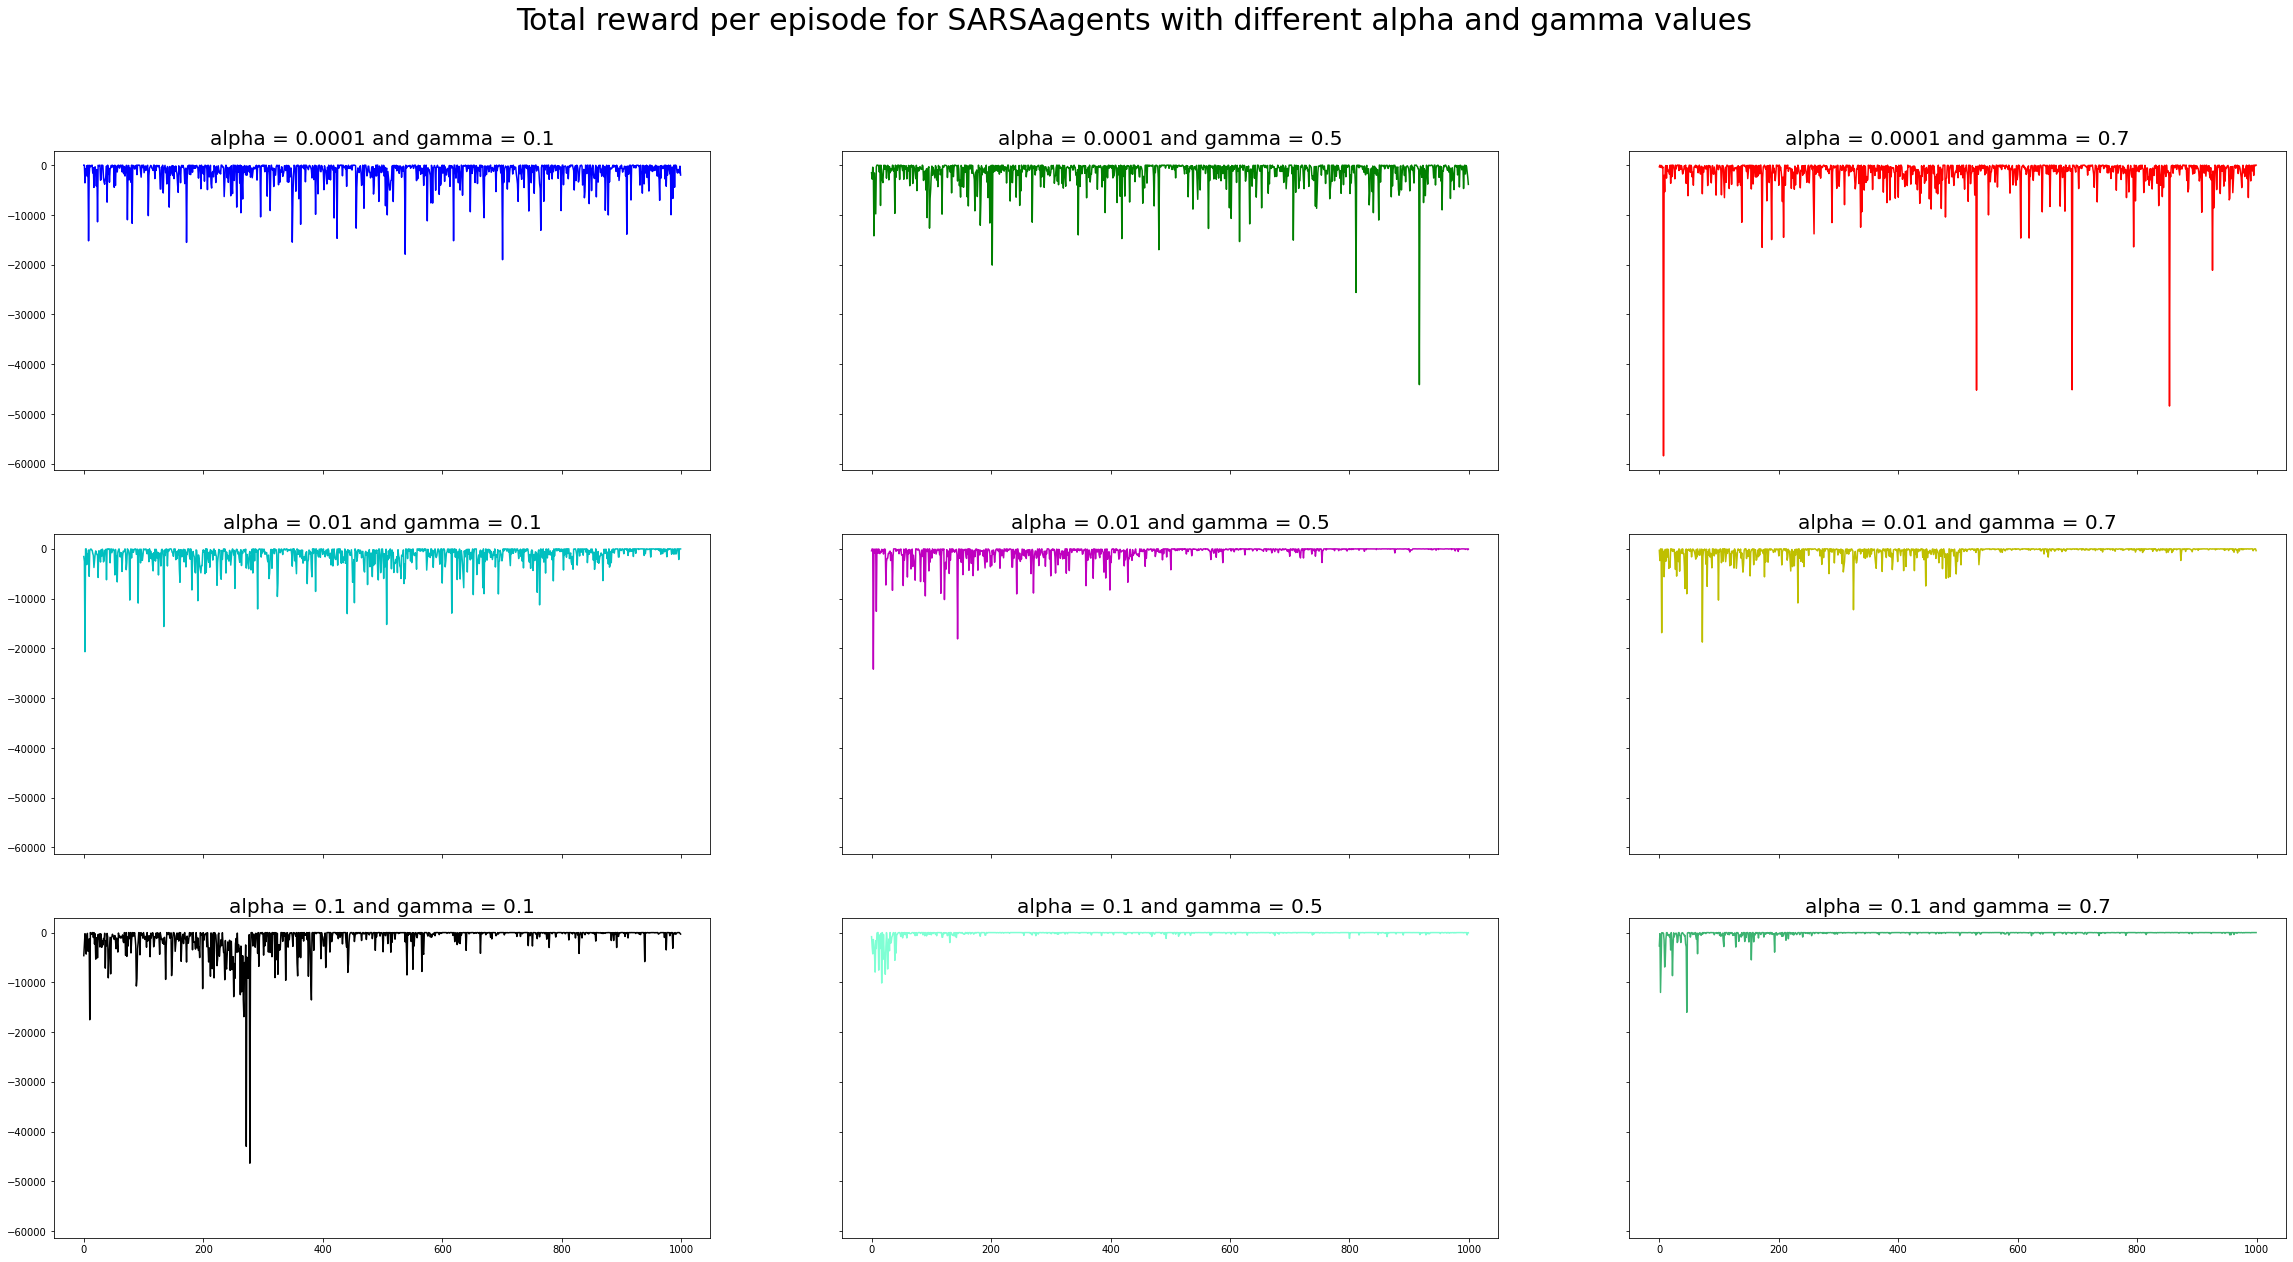

In [11]:
colors = ['b','g','r', 'c', 'm', 'y', 'k', 'aquamarine', 'mediumseagreen']
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(40,20))
subfigs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8, ax9]

fig.suptitle('Total reward per episode for SARSAagents with different alpha and gamma values', size=30)
for i in range(len(agentlist)):
    subfigs[i].plot(range(0,episodes), rewards_agents[i], color = colors[i])
    subfigs[i].title.set_text("alpha = {} and gamma = {}".format(alphagamma[i][0], alphagamma[i][1]))
    subfigs[i].title.set_size(20)

for ax in fig.get_axes():
    ax.label_outer()
    
#fig.savefig("combination_SARSAagent.png")

Put your plots here. (In case your code takes too long to run.) 

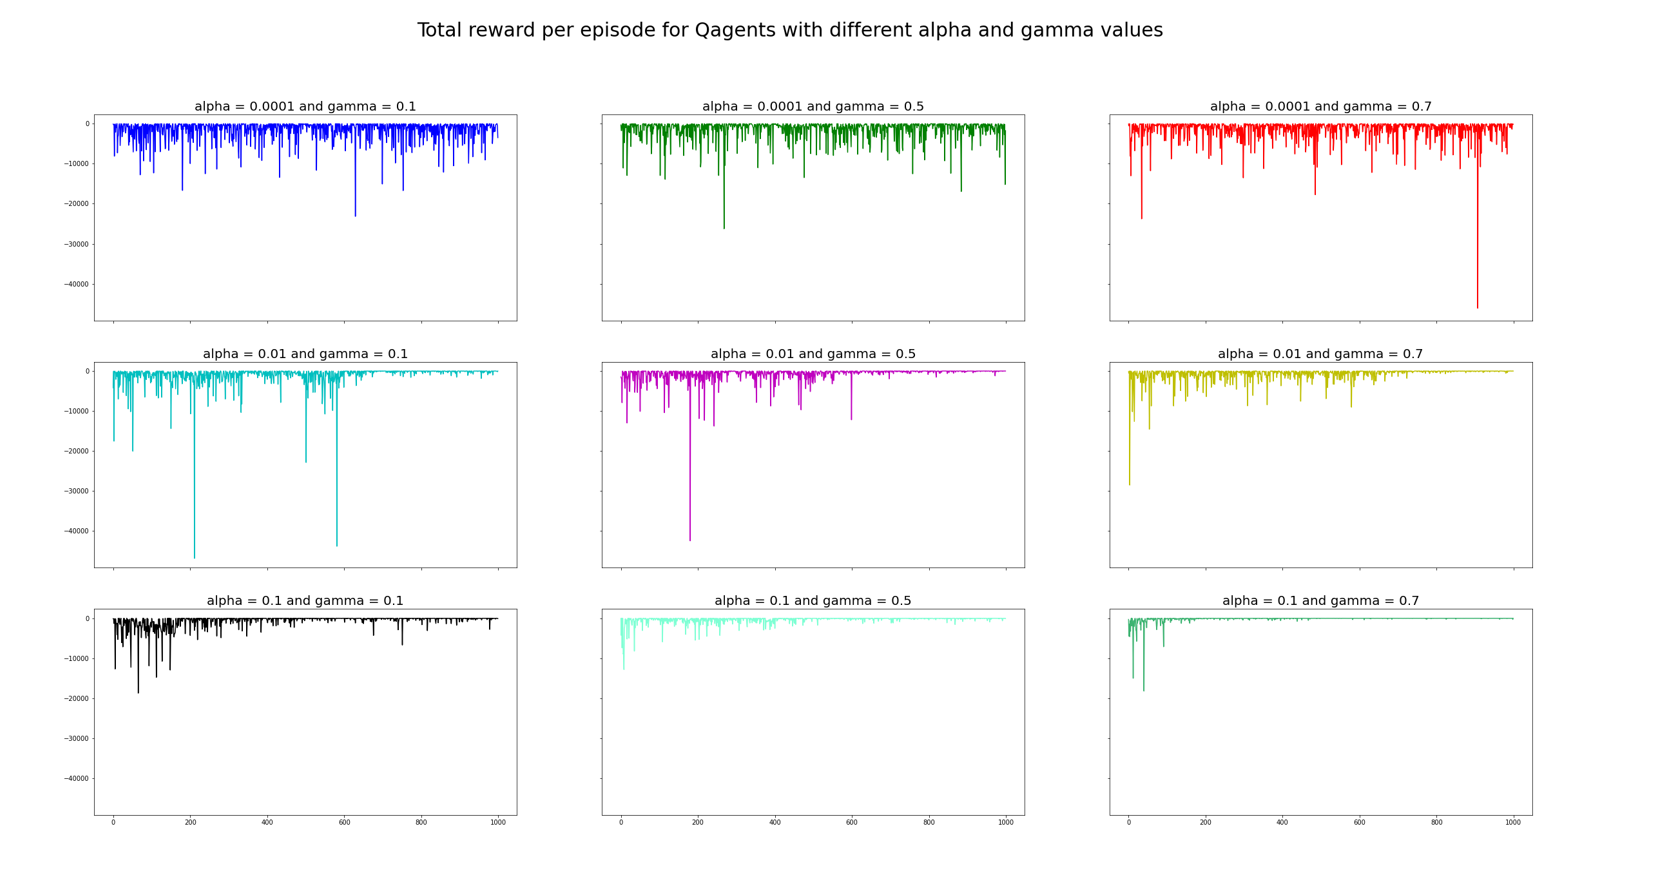

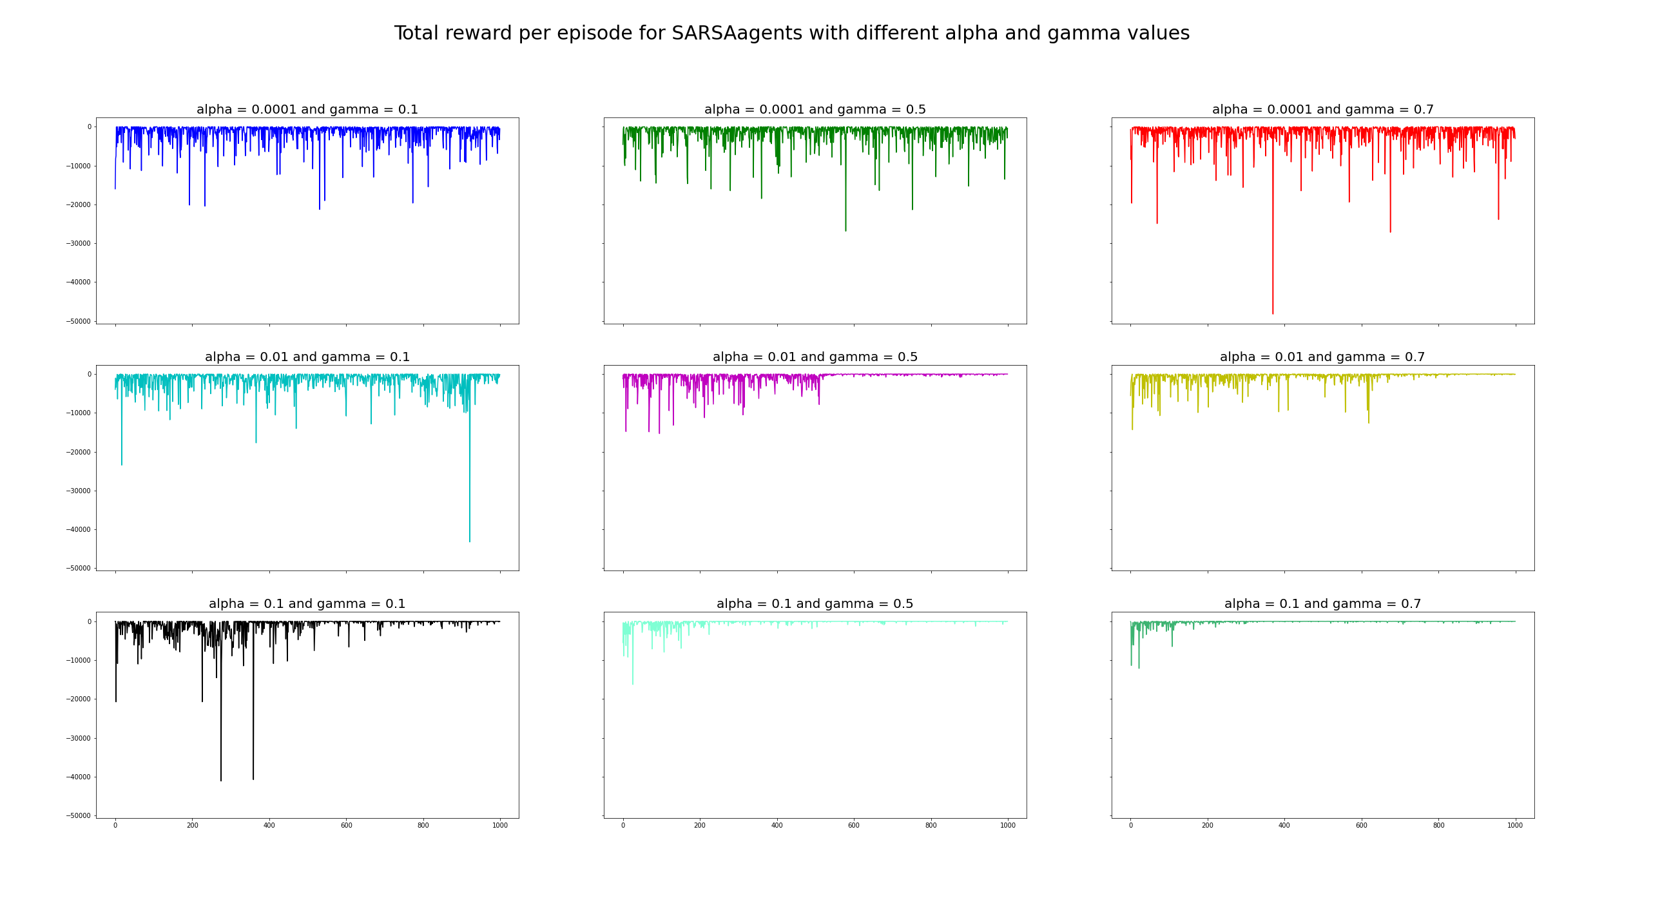

**3.2 Please interpret the results/plots (2 points)**. Explain how two algorithms differ in the learning procedure from another and what the results say about the parameters alpha (step-size) and gamma (decay-rate).

###Explain how two algorithms differ in the learning procedure from another. 

The Sarsa algorithm is an On-Policy algorithm (as we saw in the lecture) for TD-Learning and Q-learning is an Off-Policy algorithm. The major difference between Sarsa and Q-Learning, is that Q-Learning takes the maximum possible reward of the next state and ignores whatever policy we are using. On the other hand, Sarsa will still follow the policy (e-greedy) to compute the next state and pass the reward corresponding to that back to the previous step.

###What do the results say about the parameters alpha (step-size)

We look seperately at the variables alpha for a fixed gamma. First we will state the results and at the end we will interpret and explain the results and what it says about alpha.

*   For gamma = 0.1 we varied our alpha by 0.0001, 0.01 and 0.1. 
For convergency, we see that the QAgent coverges faster for alpha = 0.01 and alpha = 0.1. For alpha = 0.0001 we don't see a significant difference of convergency between QAgent and SARSA Agent. 
For performance, we see that QAgent outperforms SARSA Agent in the case alpha = 0.01, and in the case for alpha = 0.1 QAgent performs in general also better than SARSA Agent. For alpha = 0.0001 it's not easy to tell which agent performs better by just looking at the graph. 
Overall, for QAgent, alpha = 0.01/0.1 both converges pretty fast and converged to a reward close to zero, however, for SARSA, it was only the case for alpha = 0.1 that the reward converged close to 0.


*   For gamma = 0.5 we varied our alpha by 0.0001, 0.01 and 0.1. 
For convergency, we see that for alpha = 0.0001 both QAgent and SARSA Agent didn't converge. For alpha = 0.01, QAgent and SARSA Agent converges almost at the same time (around 500-600), but for alpha = 0.1 SARSA converges slightly faster. 
For the permormance, SARSA have a bit better performance for the case  alpha = 0.01, but for alpha = 0.0001 and alpha = 0.1 QAgent performs better. 
For both cases alpha = 0.1 converges the fastest and for alpha = 0.01 and alpha = 0.1 had the same performance (close to zero) when it converged.

*   For gamma = 0.7 we varied our alpha by 0.0001, 0.01 and 0.1. 
Here we see that for both convergency and performance both algorithms performs almost the same results. Note that only for alpha = 0.0001 both algoritmhs didn't converge, and for alpha = 0.1 it converges incredibly fast for both QAgent and SARSA Agent.

The parameter alpha shows how much we should adjust our estimates based on the error. The learning rate or step size alpha is between 0 and 1. A large step size adjusts aggressively and might lead to fluctuating training results, in other words, it will not converge. A small learning rate adjusts slowly, which will take more time to converge.
As we see for all cases, alpha = 0.0001 didn't converge due to the too small step size alpha. And alpha = 0.1 converges overall the fastest. So we could say that for this specific task, an bigger alpha (hereby we mean of the choices 0.0001 till 0.1) would be suggested in order to get a quick convergence and a good performance.

###What do the results say about the parameters gamma (decay-rate)?
Now, we look seperately at the variables gamma for a fixed alpha. First we will state the results and at the end we will interpret and explain the results and what it says about gamma, the same as how we did above.


*   For alpha = 0.0001, we varied gamma with 0.1, 0.5 and 0.7.
In this case we see that for all cases both Q and SARSA didn't converge. The performance is also not obvious better for any of the gamma values.

*   For alpha = 0.01, we varied gamma with 0.1, 0.5 and 0.7.
For QAgent we see that for all gammas it converges at around 600 episodes but we do see that for a higher value of gamma the overall performance is slightly better.
For SARSA, we see for gamma = 0.1 it haven't converged yet, and for gamma = 0.5 it does at around episode = 500 and for gamma = 0.7 it does as well at around 600 episodes. 
Here we see that gamma = 0.5/0.7 outperforms gamma = 0.1.

*   For alpha = 0.01, we varied gamma with 0.1, 0.5 and 0.7.
Here again we see that gamma = 0.5/0.7 outperforms gamma = 0.1 in both algorithms. Furthermore, gamma = 0.5 converges at around episode 400 for QAgent and episode 100 for SARSA Agent and for gamma = 0.7 it converges at around episode 100 for QAgent and episode 100 for SARSA Agent.


The parameter gamma, standing for the decay rate or discount rate, tells us how much we are valuing future rewards. The decay rate is a value between 0 and 1. The bigger the discount rate, the more we valuing the future rewards. And it seems at least for this task, a bigger gamma of 0.5 or even 0.7 would increase the convergency and overall performance. For all fixed alpha's we saw that gamma = 0.5 or 0.7 outperformed gamma = 0.1 and most of the times gamma = 0.7 performed even a slightly better than gamma = 0.5 as well. Thus, this means that valuing future rewards more, would lead to a better result.


###Conclusion about parameters
We see that for both QAgent and SARSA Agent the combination of parameters alpha = 0.1 and gamma = 0.7 gave us the best result. Meaning a greater stepsize and a big decay rate would be suggested in this task!



**3.3 Let think one step further by looking at the policies you have learned (1.5 points).** 

Please compare the performance of your learned optimal policies using another simulation. In this simulation, you shall have three agents (Qlearning_Agent, SARSA_agent and Random_agent), where all three agents always use their initial policy to behave and find the goal in the given map (make sure the agent does NOT learn anymore!). The initial policies of Qlearning_Agent and SARSA_agent are the optimal policies learned from the above experiments (based on the final estimated Q-values using Q-learning and SARSA algorithm respectively). The inital policy of Random_Agent will select 4 actions randomly. There is no need to submit your codes for this question.

Describe the performance of three agents by running each agent on the task and discuss the results (1.5 points). You can use the render function provided above (and other helper functions) observe the different behaviors of three agents. You could also use an appropriate plot to show the different performances. 

Some questions you shall think about and answer (in case there are no differences or no special things, just indicate what you observed):
- How does the learned Q-learning policy and SARSA policy perform differently? Does it show the difference between on-policy and off-policy methods?
- What kind of strategy did the two RL agents learn similarly? How do they differ from the random policy?
- For the RL-learned policies, do you still observe something that does not perform so well? Can you think about possible ways to improve/solve it?

### To uncomment the follwoing code please use: Ctrl + /
### Or just look at the plots below

In [15]:
# #First let Q and SARSA Learn
# env = Environment()
# epsilon = 0.01
# gamma = 0.7
# alpha = 0.1
# episodes = 1000

# agentS = SARSAAgent(alpha, gamma, epsilon)
# agentQ = QAgent(alpha, gamma, epsilon)
# agentSQ = [agentS, agentQ]
# agentSQR = []

# for a in agentSQ:
#   agent = a
#   ep = 0
#   rewards_per_episode = []
#   while ep < episodes:
#     start_state = env.reset()
#     end_state, total_reward, animation_data = run_episode(env, agent, start_state, is_learning= True, is_rendering=True)
#     ep = ep + 1
#     rewards_per_episode.append(total_reward)
#   agentSQR.append(agent)

# agentR = SARSAAgent(alpha, gamma, 1)
# agentSQR.append(agentR)

# #Now, let run it without learning.
# rewards_agentsSQR = []
# for a in agentSQR:
#   agent = a
#   ep = 0
#   rewards_per_episode = []
#   while ep < episodes:
#     start_state = env.reset()
#     end_state, total_reward, animation_data = run_episode(env, agent, start_state, is_learning= True, is_rendering=True)

#     rewards_per_episode.append(total_reward)
#     ep = ep + 1
#   rewards_agentsSQR.append(rewards_per_episode) #list of lists

(10, 10, 4)
<class 'numpy.ndarray'>


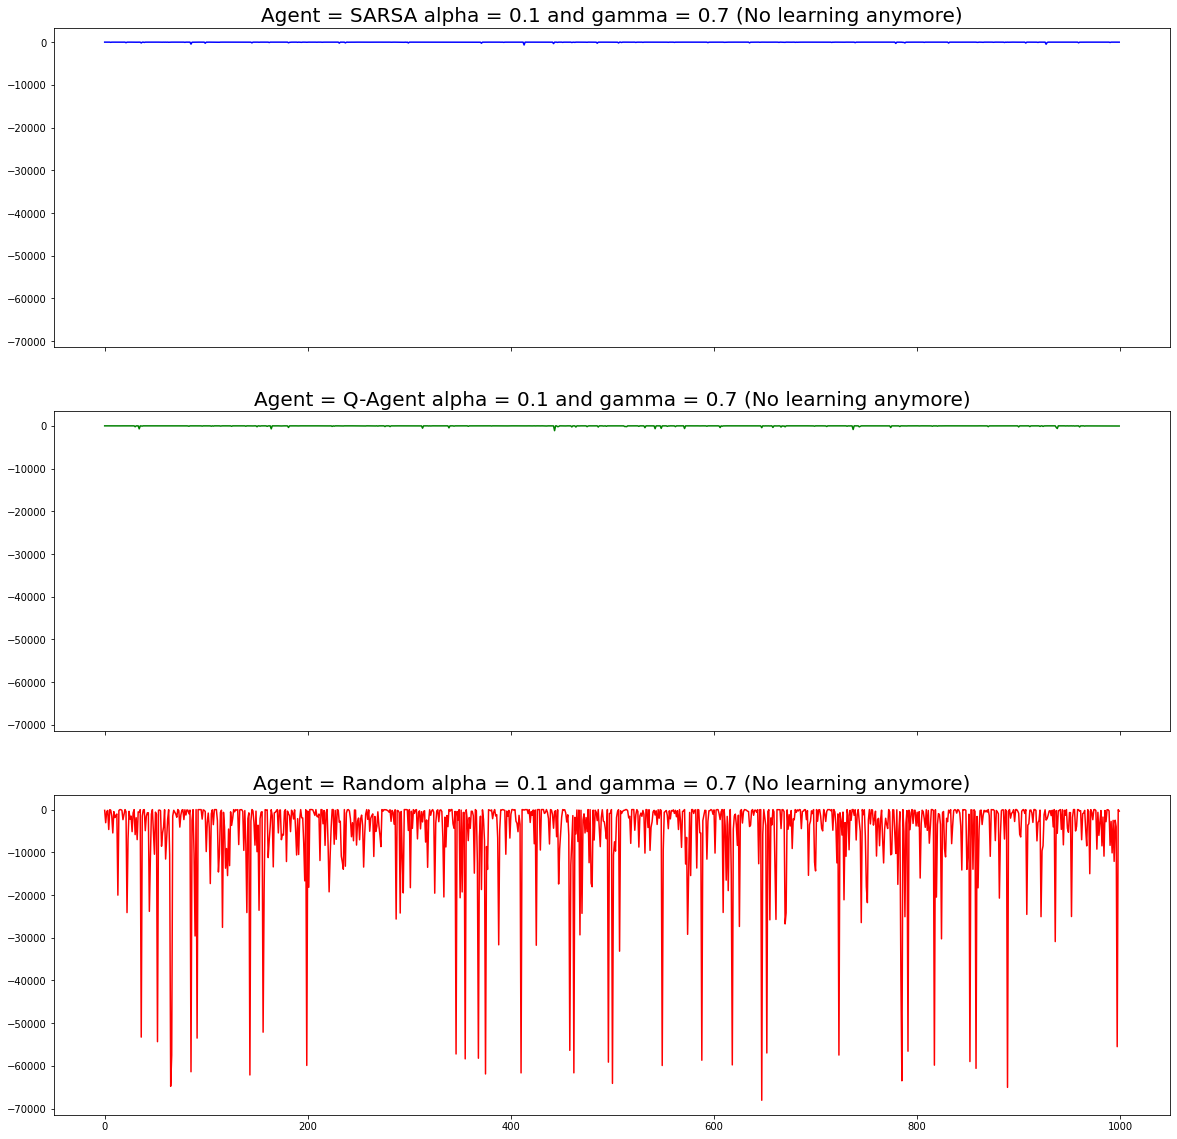

In [16]:
# colors = ['b','g','r']
# fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(20,20))
# subfigs = [ax1,ax2,ax3]
# agentname = ["SARSA", "Q-Agent", "Random"]
# for i in range(len(agentSQR)):
#   subfigs[i].plot(range(0,episodes), rewards_agentsSQR[i], color = colors[i])
#   subfigs[i].title.set_text("Agent = {} alpha = 0.1 and gamma = 0.7 (No learning anymore)".format(agentname[i]))
#   subfigs[i].title.set_size(20)

# for ax in fig.get_axes():
#     ax.label_outer()

# fig.savefig("combination_no_learning_agents.png")

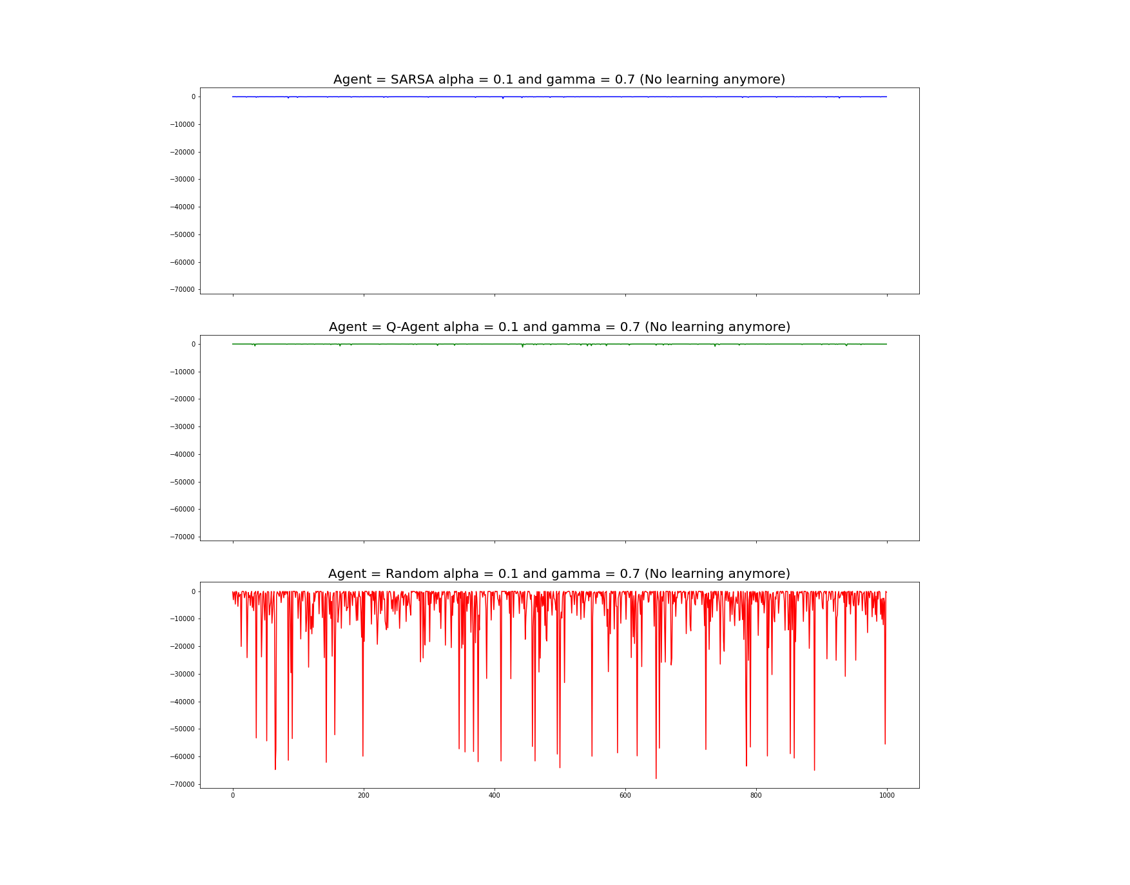

###How does the learned Q-learning policy and SARSA policy perform differently? 

As we see, we don't notice any significant differences anymore, meaning the learned Q-learning policy and SARSA policy performs now equally well after it converged before. 

###Does it show the difference between on-policy and off-policy methods?

SARSA is an on-policy method and Q-Learning an off-policy. Thus we don't see a difference in the result as well.

###What kind of strategy did the two RL agents learn similarly? 
Both agents used the strategy to learn the value of an action in a particular state> Q-learning ends up learning the optimal policy, and SARSA ends up learning a "near" optimal policy. However, in the result above, we see that both agents perform almost perfectly.

###How do they differ from the random policy?
They learned the optimal policy thus the will find the goal in way shorter tme which will lead to a higher reward. The random policy just randomly choose actions, so it will end up in the goal only by "coincidence". So they differ a lot in performance!

###For the RL-learned policies, do you still observe something that does not perform so well? 

In this case, no! And this would also depend on which alpha and gamma you use as parameters and how many episodes you run, since this will have a major influence on how well the agents learn. We have chosen an alpha and a gamma such that both agents learned the optimal policy (or near optimal policy for SARSA), so as we see above there's barely room for improvement for the agents.

###Can you think about possible ways to improve/solve it?

We might try other values of alpha and gamma (and even epsilon), but we doubt that they will perform better since the "optimal performance" is reached as we see above.



You are almost done! Before handing in, make sure that the codes you hand in work, and that all plots are shown. **Submit just one file per team.**

Again, make your you name this file according to your last names.